In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

12:13:42 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / "stimulus-spike-lfp-response"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
lfp_action = actions['stimulus-spike-lfp-response']
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [7]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
lfp_results = lfp_results.drop('unit_id', axis=1)

In [8]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [9]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
stim_results = stim_results.drop('unit_id', axis=1)

In [10]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [11]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [12]:
data = data.merge(lfp_results, how='left')

In [13]:
data = data.merge(stim_results, how='left')

In [14]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [15]:
data = data.merge(waveform_results, how='left')

In [16]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and Hz11', 'frequency==11', 'baseline and Hz30', 'frequency==30']

In [17]:
data.bs = data.bs.astype(bool)

In [18]:
data.loc[data.eval('not t_i_peak.isnull() and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak.isnull() and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [19]:
# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [20]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [21]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 231
Number of animals 4


In [22]:
gridcell_sessions

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,t_i_peak,p_i_peak,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited
14,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0087,0.000055,0.259757,0.362390,0.180529,False,0.0,NaN,True,False
21,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0008,0.000880,0.242524,0.534827,2.265039,True,1.0,NaN,False,False
29,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.279806,0.598967,10.924422,True,1.0,NaN,False,False
30,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0005,0.002365,0.265158,0.581451,3.984881,True,1.0,NaN,False,False
31,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.246920,0.570844,3.497452,True,1.0,NaN,False,False
33,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,NaN,NaN,0.272875,0.602667,5.945508,True,NaN,1.0,False,False
34,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,NaN,NaN,0.226452,0.274814,2.860048,False,NaN,0.0,False,True
35,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,NaN,NaN,0.247266,0.570104,3.365674,True,NaN,1.0,False,False
39,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,NaN,NaN,0.284542,0.644111,17.471520,True,NaN,1.0,False,False
40,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,NaN,NaN,0.259920,0.581698,5.891739,True,NaN,1.0,False,False


In [23]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [24]:
data.query('baseline and Hz11 and gridcell').head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited,gridcell,bs_not_gridcell
33,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.272875,0.602667,5.945508,True,NaN,1.0,False,False,True,False
34,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.226452,0.274814,2.860048,False,NaN,0.0,False,True,True,False
35,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.247266,0.570104,3.365674,True,NaN,1.0,False,False,True,False
39,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.284542,0.644111,17.471520,True,NaN,1.0,False,False,True,False
40,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.259920,0.581698,5.891739,True,NaN,1.0,False,False,True,False


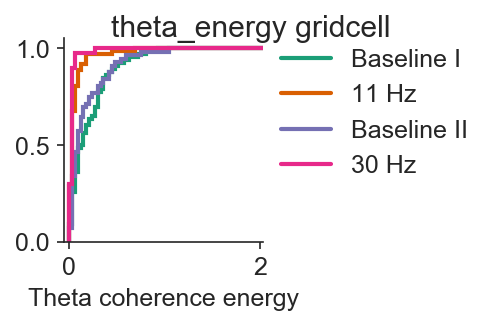

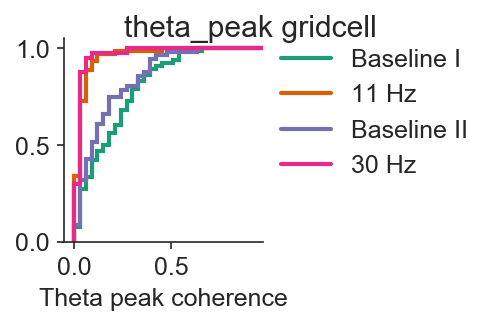

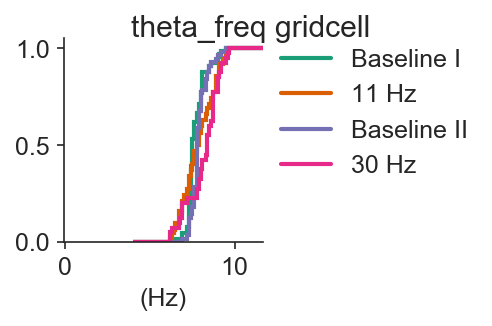

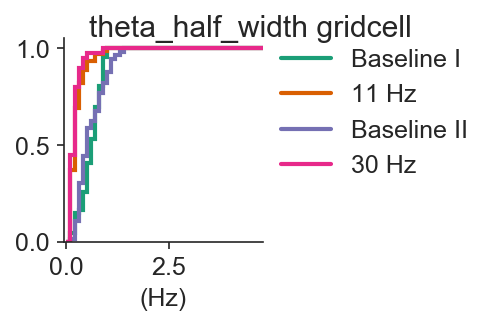

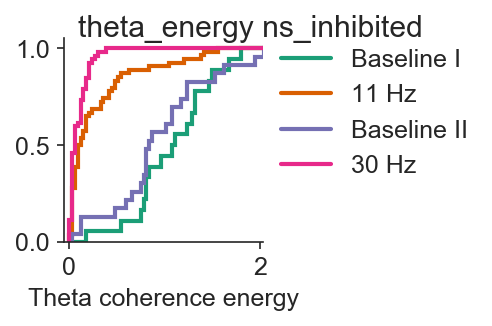

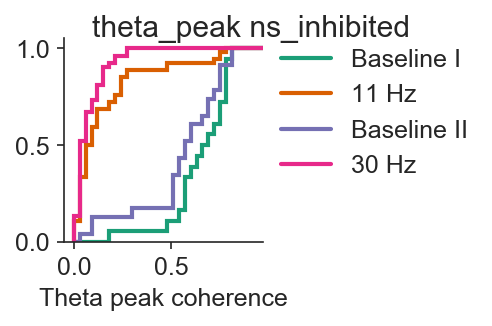

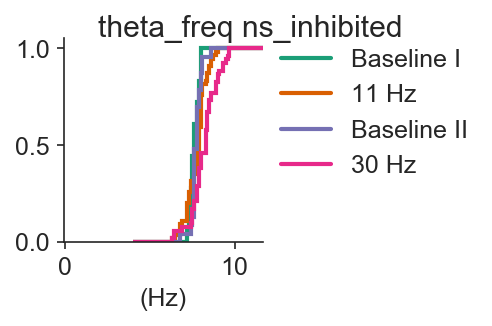

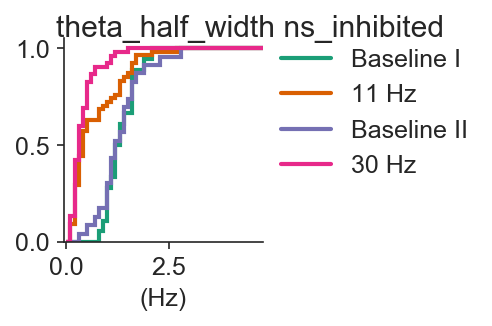

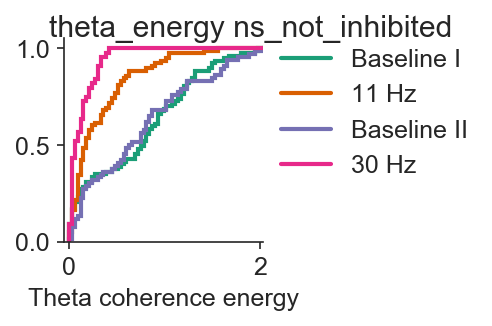

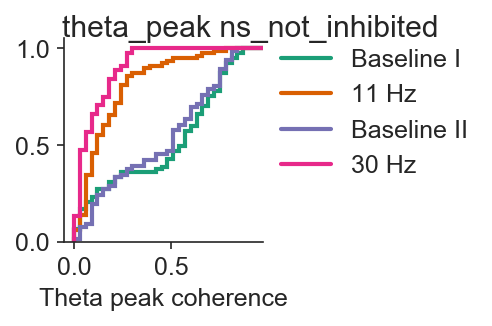

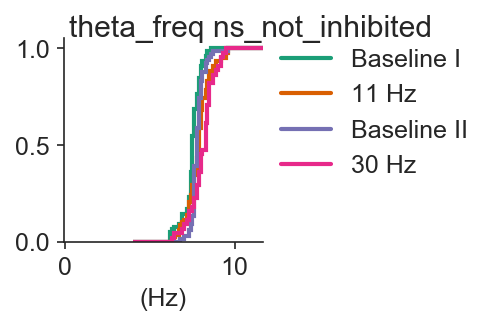

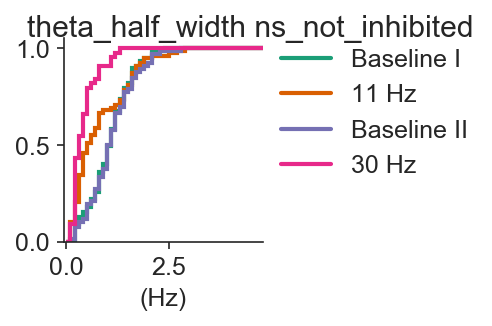

In [25]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'theta_energy': np.arange(0, 2.1, .03),
    'theta_peak': np.arange(0, 1, .03),
    'theta_freq': np.arange(4, 12, .1),
    'theta_half_width': np.arange(0, 5, .1)
}
xlabel = {
    'theta_energy': 'Theta coherence energy',
    'theta_peak': 'Theta peak coherence',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
}

for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in bins:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data.query(query + ' and ' + cell_type)[key].hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [26]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

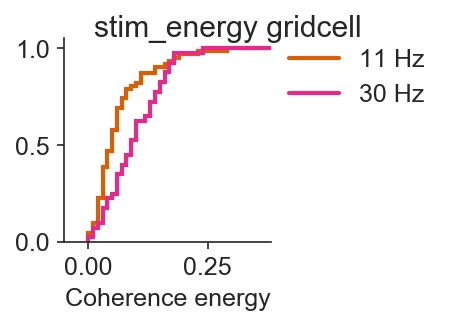

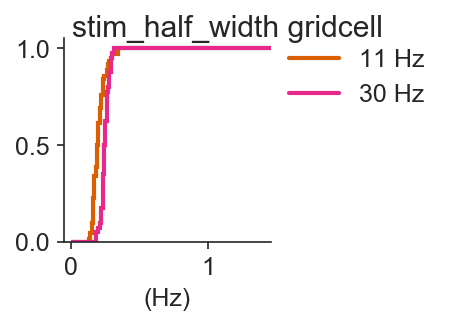

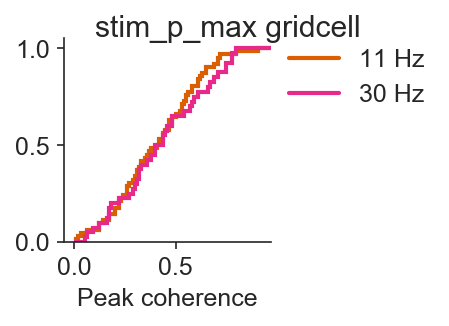

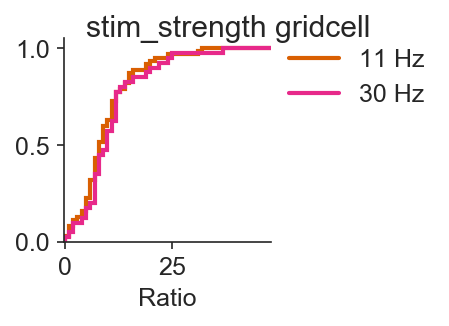

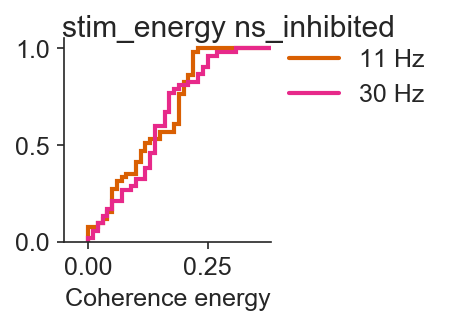

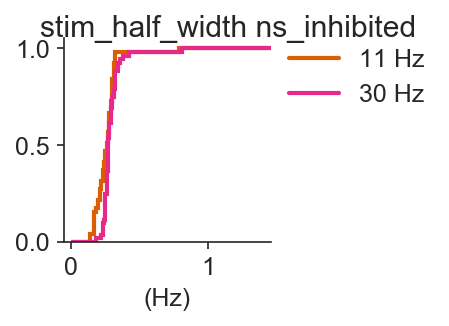

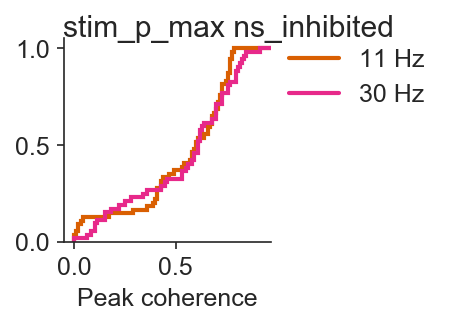

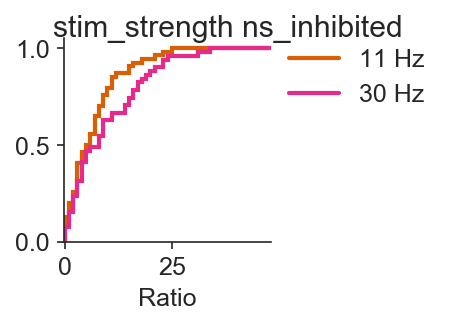

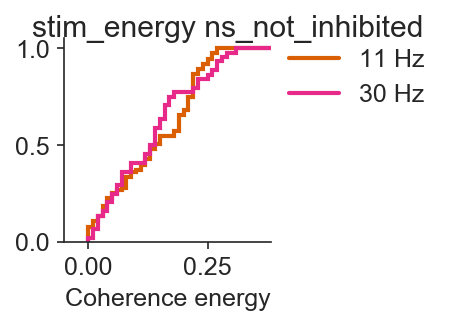

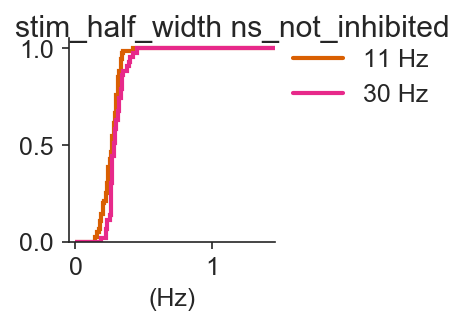

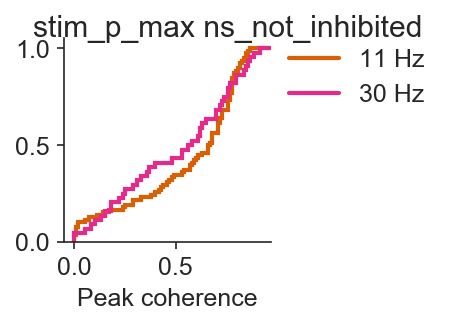

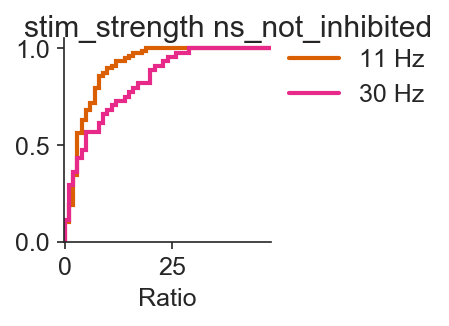

In [27]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'stim_energy': np.arange(0, .4, .01),
    'stim_half_width': np.arange(0, 1.5, .01),
    'stim_p_max': np.arange(0, 1, .01),
    'stim_strength': np.arange(0, 50, 1)
}
xlabel = {
    'stim_energy': 'Coherence energy',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak coherence',
    'stim_strength': 'Ratio',
}
# key = 'theta_energy'
# key = 'theta_peak'
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in bins:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors[1::2], queries[1::2], labels[1::2]):
            data.query(query + ' and ' + cell_type)[key].hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [28]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [29]:
coher = pd.read_feather(output_path / 'data' / 'coherence.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [30]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

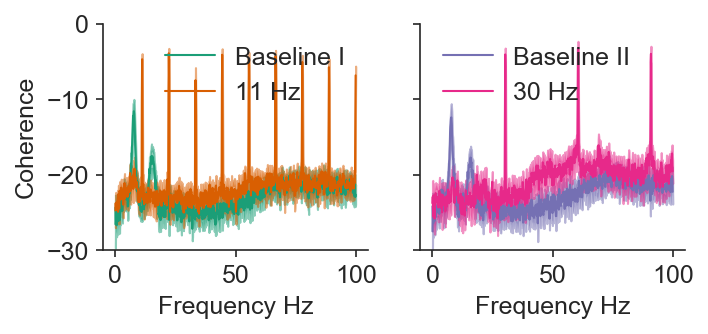

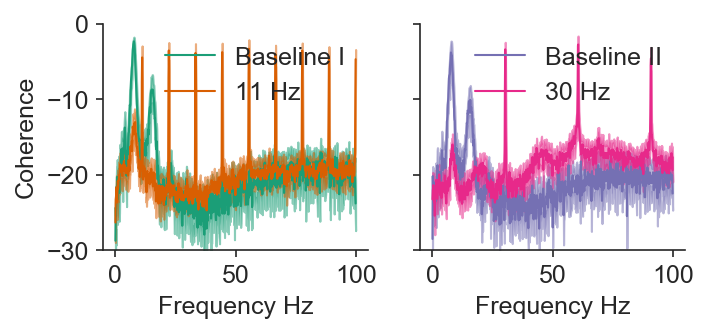

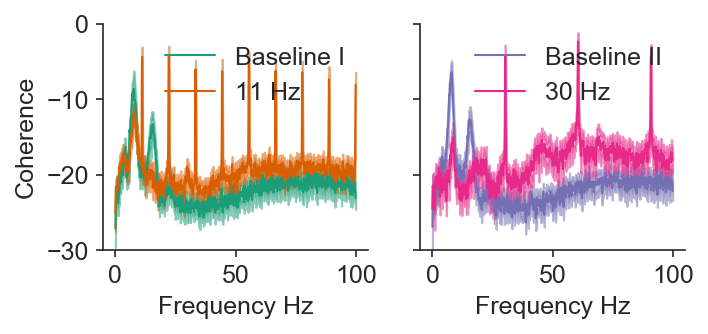

In [31]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
    #     ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
        ax.set_ylim(-30, 0)
    axs[0].set_ylabel('Coherence')
    despine()
    figname = f'spike-lfp-coherence-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [32]:
action = project.require_action("stimulus-spike-lfp-response")

In [33]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/data/freqs.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/data/coherence.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-theta_freq-ns_not_inhibited.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-stim_strength-not-bs.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-stim_energy-not-bs.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-theta_peak-gridcell.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spike-lfp-coherence-histogram-theta_energy-ns_inhibited.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response/data/figures/spik

In [34]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-lfp-response.ipynb")